<a href="https://colab.research.google.com/github/wantor-stack/fernando-pessoa/blob/master/Copy_of_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de poemas do Fernando Pessoa
## Grupo Turing - NLP

## Passo 0: importando as bibliotecas

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 5.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=ef693391ef0a69366a81e56581a88e7f1c34e726c0959be15f8dba8910af4b9b
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2MB 65.3MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp37-none-any.whl size=21186283 sha256=aaf4d798985963a3c5e4b516a71f219f73f426b622a5418bd3a99d6c7d16b8b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8k9x01h9/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
import re
import unicodedata

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer
from langdetect import detect, DetectorFactory
import spacy
from spacy.lang.pt.examples import sentences

In [ ]:
nltk.download('stopwords')
tqdm.pandas()
DetectorFactory.seed = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Passo 1: carregar o dataset e filtrar por autores mais frequentes

In [ ]:
dados = pd.read_csv('fernando_pessoa.csv')
dados.drop(['id', 'titulo', 'data', 'bibliografia'], inplace=True, axis=1)
dados.reset_index(drop=True, inplace=True)

Nesse passo, optamos por trabalhar com os autores com mais de 80 textos, pois menos que isso poderia ocasionar um sobreajuste. 

In [ ]:
dados = dados.groupby('autor').filter(lambda x : (x['autor'].count()>=80).any())

Além disso, percebemos que no corpus há muitos textos em inglês, para isso utilizamos a função **detect** da biblioteca *langdetect*. Isso eliminou certa de 625 textos.

In [ ]:
dados['port'] = dados['texto'].progress_apply(lambda x: detect(x) != 'en')
dados = dados[dados['port'] == True]
dados.reset_index(inplace = True)

100%|██████████| 4383/4383 [00:42<00:00, 103.10it/s]


## Passo 2: Preprocessamento: stemização, lematização, etc. 

Ao analisar os textos, vimos que muitas palavras começavam com um travessão ou *underscore* indicador de diálogo. Para resolver tal problema, criamos a função `remover_underscore`, que lidou bem com o problema. 

In [ ]:
def remover_underscore(palavra):
    if palavra[0] == '_' or palavra[-1] == '_':
        return palavra.replace('_', '')
    else:
        return palavra

Também percebemos que palavras acentuados prejudicam o modelo de stemização e de lematização, portanto optamos por remover todos os acentos. A função `remover_acento` talvez poderia ser mais simples, entretanto foi a solução encontrada. 

In [ ]:
def remover_acento(texto):
    try:
        texto = unicode(texto, 'utf-8')
    except NameError:
        pass
    texto = unicodedata.normalize('NFD', texto)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(texto)

Por último, tanto na stemização, quanto na lematização, foi importante remover _stopwords_ do texto. Para isso, usaremos a lista de stopwords em português que o NLTK fornece. Além disso, também usamos expressões regulares (*regex*) para eliminar quaisquer caracteres que pudessem poluir o texto.

In [ ]:
stopwords_pt = set(stopwords.words('portuguese'))

def remover_stopwords(texto, lista=False):
    palavras = re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())
    sem_stopwords = [p for p in palavras if p not in stopwords_pt]
    if lista:
        return sem_stopwords
    else:
        return ' '.join(sem_stopwords)

### Passo 2.1: stemização utilizando SnowBall

Aqui criamos as duas funções mais importantes do preprocessamento do texto. A primeira, `stemizar`, recebe o texto não processado e o devolve com as palavras stemizadas e sem stopwords. Para isso, utilizamos o algoritmo *Snowball* criado por Martin Porter. A biblioteca do NLTK conta com um stemizador chamado `PortugueseStemmer` e é ele que utilizaremos.

In [ ]:
def stemizar(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    stemizador = PortugueseStemmer()
    palavras = []

    for p in palavras_importantes:
        novo_p = remover_underscore(remover_acento(p))
        palavras.append(stemizador.stem(novo_p))
    return ' '.join(palavras)

### Passo 2.2: lematização utilizando spaCy

A outra função criada foi a `lematizar`. Similar à função anterior, essa função recebe o texto não processado e o devolve com os verbos lematizados. Para isso, utilizamos os modelos da biblioteca **spaCy**, a qual conta também com ferramentas de marcação de partes do discurso, utilizadas na função para separar os verbos a serem lematizados. 

In [ ]:
nlp = spacy.load("pt_core_news_sm")

def lematizar(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    texto_importante = ' '.join(palavras_importantes)
    texto_importante = remover_underscore(remover_acento(texto_importante))
    
    doc = nlp(texto_importante)
    doc_lematizado = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in doc]
    return ' '.join(doc_lematizado)

Finalmente, aplicamos as duas funções ao corpus, gerando as colunas *texto_stemizado*, *texto_lematizado*, *texto_sem_stopwords* e *texto_l_s* (combinação de lematização e stemização).

In [ ]:
dados['texto_stemizado'] = dados.texto.progress_apply(stemizar)
dados['texto_lematizado'] = dados.texto.progress_apply(lematizar)
dados['texto_l_s'] = dados.texto.progress_apply(lambda x: stemizar(lematizar(x)))
dados['texto_sem_stopwords'] = dados.texto.progress_apply(remover_stopwords)

100%|██████████| 3759/3759 [00:00<00:00, 8182.74it/s]


In [ ]:
dados.head()

index  ...                                texto_sem_stopwords
0      0  ...  diana através ramos espreita vinda endymion en...
1      1  ...  reforma calendário consequências comerciais co...
2      3  ...  aqui outro apolo apolo suspiro abandonemos cri...
3      5  ...  ceres anoitece píncaros ainda faz luz sinto tã...
4      8  ...  ti odeio cristo és deus eterno pantéon preside...

[5 rows x 9 columns]

## Passo 3: criação do modelo

Para treinamento do modelo, optamos por utilizar os 4 heterônimos com mais textos (Bernardo Soares, Álvaro de Campos, Ricardo Reis e Alberto Caeiro). Os textos classificados como Fernando Pessoa serão utilizados para treinar o modelo de *tf-idf*, mas não serão utilizados para treinar os modelos de classificaçã.

In [ ]:
dados.autor.value_counts()

Fernando Pessoa     2327
Bernardo Soares      503
Álvaro de Campos     393
Ricardo Reis         307
Alberto Caeiro       127
António Mora          95
Alexander Search       7
Name: autor, dtype: int64

Criamos então o DataFrame `autores_principais`, o qual contém os quatro heterônimos mais frequentes.

In [ ]:
autores_principais = ['Bernardo Soares', 'Álvaro de Campos', 'Ricardo Reis', 'Alberto Caeiro']
dados_principais = dados[dados['autor'].isin(autores_principais)].copy()
dados_principais.autor.value_counts()

Bernardo Soares     503
Álvaro de Campos    393
Ricardo Reis        307
Alberto Caeiro      127
Name: autor, dtype: int64

### Passo 3.1: codificação dos autores

Para podermos montar um modelo classificatório, precisamos lidar com a coluna categórica *author* do DataFrame. O `LabelEncoder` do **scikit-learn** é capaz de lidar com o problema. 

In [ ]:
le = LabelEncoder()
dados_principais['autor_codificado'] = le.fit_transform(dados_principais['autor'])

In [ ]:
dados_principais.head()

index  ... autor_codificado
0      0  ...                2
2      3  ...                2
3      5  ...                2
4      8  ...                2
6     10  ...                1

[5 rows x 10 columns]

### Passo 3.2: divisão do DataFrame em treino e teste

Para essa tarefa, utilizamos `train_test_split`, com o DataFrame de teste contendo 10% do conteúdo do DataFrame original.

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(
    dados_principais[['texto', 'texto_stemizado', 'texto_sem_stopwords', 'texto_l_s', 'texto_lematizado']],
    dados_principais['autor_codificado'],
    test_size = 0.1,
    random_state = 42,
)

### Passo 3.3: criação do tf-idf

Para criação do vetor do *tf-idf* utilizamos o texto lematizado e depois stemizados de **todos** autores. Depois aplicamos a transformação aprendida em todo o corpus nos DataFrames de teste e treino.

In [ ]:
tfidf_vector = TfidfVectorizer()
tfidf_vector.fit(dados_principais['texto_l_s'])

train_X_tfidf = tfidf_vector.transform(train_X['texto_l_s'])
test_X_tfidf = tfidf_vector.transform(test_X['texto_l_s'])

dados_principais_tfidf = tfidf_vector.transform(dados_principais['texto_l_s'])

### Passo 3.4: aplicando modelos

Nesse notebook, optamos por utilizar dois modelos clássicos para classificação de texto utilizando *tf-idf*: *Gaussian Naive Bayes* e *Support Vector Machine*. Uma explicação detalhada dos modelos pode ser encontrada na nossa página do Medium: [Turing Talks](https://medium.com/turing-talks).

#### 3.4.1 GaussianNaiveBayes

In [ ]:
nb = GaussianNB()
nb.fit(train_X_tfidf.toarray(), train_Y)
predictions_nb = nb.predict(test_X_tfidf.toarray())
acuracia = accuracy_score(predictions_nb, test_Y)
print(f"Acurácia do Naive Bayes: {acuracia*100:.3f}%")

Acurácia do Naive Bayes: 60.902%


#### 3.4.2 Support Vector Machine

In [ ]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf, train_Y)
predictions_svm = svm.predict(test_X_tfidf)
acuracia = accuracy_score(predictions_svm, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")

Acurácia da SVM: 82.707%


In [ ]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm.fit(train_X_tfidf, train_Y)
predictions_svm = svm.predict(test_X_tfidf)
acuracia = accuracy_score(predictions_svm, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")

Acurácia da SVM: 82.707%


A SVM obteve resultados muito mais satisfatórios. Além disso, durante os testes, a utilização da coluna *texto_l_s* aumentou em cerca de 8% a acurácia do modelo e por isso ela foi a escolhida para ser utilizada.

#### 3.4.3 Hyperparameters

In [ ]:
# Define the Parameters and fit the model

parameters = {'C':[0.001, 0.01, 0.1, 1, 10],
             'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
             'gamma':('scale', 'auto'),
             'degree': [1, 2, 3, 4, 5, 6]}
svm = SVC()
clf = GridSearchCV(svm, parameters, cv=5, n_jobs=-1)
clf.fit(train_X_tfidf, train_Y)
#svm.fit(train_X_tfidf, train_Y)



GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
clf.cv_results_['mean_test_score']
#predictions_svm = svm.predict(test_X_tfidf)
#acuracia = accuracy_score(predictions_svm, test_Y)
#print(f"Acurácia da SVM: {acuracia*100:.3f}%")

array([0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 ,
       0.3751046 , 0.3751046 , 0.3751046 , 0.3751046 , 0.37510

In [ ]:
df = pd.DataFrame(clf.cv_results_['params'])
df['mean_test_score'] = clf.cv_results_['mean_test_score']
df.sort_values(by='mean_test_score').tail(20)

C  degree  gamma  kernel  mean_test_score
224  10.0       5  scale  linear         0.755237
193  10.0       1  scale    poly         0.755237
200  10.0       2  scale  linear         0.755237
216  10.0       4  scale  linear         0.755237
196  10.0       1   auto  linear         0.755237
192  10.0       1  scale  linear         0.755237
212  10.0       3   auto  linear         0.755237
144   1.0       1  scale  linear         0.756932
145   1.0       1  scale    poly         0.756932
148   1.0       1   auto  linear         0.756932
152   1.0       2  scale  linear         0.756932
176   1.0       5  scale  linear         0.756932
156   1.0       2   auto  linear         0.756932
160   1.0       3  scale  linear         0.756932
188   1.0       6   auto  linear         0.756932
168   1.0       4  scale  linear         0.756932
184   1.0       6  scale  linear         0.756932
172   1.0       4   auto  linear         0.756932
180   1.0       5   auto  linear         0.756932
164   1.0       3   auto  linear         0.756932

In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.756931659693166


## Passo 4: visualizando os vetores do tf-idf utilizando redução de dimensionalidade

Afim de obtermos uma visualização do *tf-idf*, aplicamos a transformação individualmente para cada autor e então reduzimos o vetor a duas dimensões utilizando o algoritmo **PCA**. A utilização de algoritmos mais complexos também se mostrou viável, mas optamos por não colocar suas aplicações nesse notebook.

### Passo 4.1: aplicando *tf-idf* para cada heterônimo 

In [ ]:
bernardo = dados_principais[dados_principais.autor == 'Bernardo Soares']
ricardo = dados_principais[dados_principais.autor == 'Ricardo Reis']
campos = dados_principais[dados_principais.autor == 'Álvaro de Campos']
alberto = dados_principais[dados_principais.autor == 'Alberto Caeiro']

bernardo_tfidf = tfidf_vector.transform(bernardo.texto_stemizado)
ricardo_tfidf = tfidf_vector.transform(ricardo.texto_stemizado)
campos_tfidf = tfidf_vector.transform(campos.texto_stemizado)
alberto_tfidf = tfidf_vector.transform(alberto.texto_stemizado)

### Passo 4.2: aplicando PCA nos vetores do *tf-idf* e então utilizando matplotlib para visualizar os resultados

Nesse passo, utlizamos uma simples transformação para duas dimensões e então plotamos o PCA em um scatter do matplotlib.

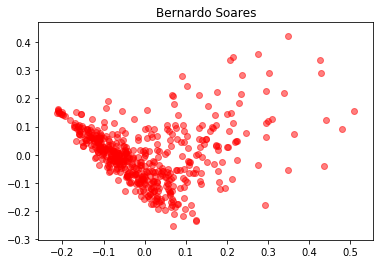

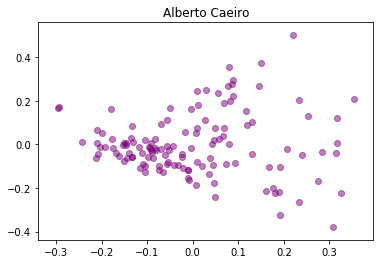

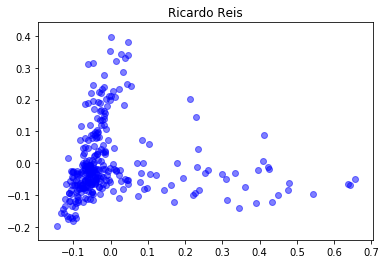

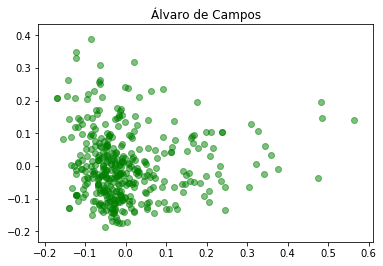

In [ ]:
data2D = PCA(n_components = 2).fit_transform(bernardo_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'red', alpha = 0.5)
plt.title('Bernardo Soares')
plt.show()

data2D = PCA(n_components = 2).fit_transform(alberto_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'purple', alpha = 0.5)
plt.title('Alberto Caeiro')
plt.show()

data2D = PCA(n_components = 2).fit_transform(ricardo_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'blue', alpha = 0.5)
plt.title('Ricardo Reis')
plt.show()

data2D = PCA(n_components = 2).fit_transform(campos_tfidf.todense())
plt.scatter(data2D[:, 0], data2D[:, 1], c = 'green', alpha = 0.5)
plt.title('Álvaro de Campos')
plt.show()